# **AlexNet**

In [ ]:
!pip install ipython-autotime
from IPython import get_ipython
get_ipython().run_line_magic('load_ext', 'autotime')

# Data Aquisition: DiBAS Dataset

In [ ]:
!git clone https://github.com/YuandiWu/DiBAS-Images.git

Cloning into 'DiBAS-Images'...
remote: Enumerating objects: 803, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (219/219), done.
remote: Total 803 (delta 8), reused 177 (delta 0), pack-reused 584
Receiving objects: 100% (803/803), 4.15 GiB | 24.63 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Updating files: 100% (690/690), done.


In [ ]:
!ls DiBAS-Images/train

Acinetobacter.baumanii	   Lactobacillus.plantarum
Actinomyces.israeli	   Lactobacillus.reuteri
Bacteroides.fragilis	   Lactobacillus.rhamnosus
Bifidobacterium.spp	   Lactobacillus.salivarius
Candida.albicans	   Listeria.monocytogenes
Clostridium.perfringens    Micrococcus.spp
Enterococcus.faecalis	   Neisseria.gonorrhoeae
Enterococcus.faecium	   Porfyromonas.gingivalis
Escherichia.coli	   Propionibacterium.acnes
Fusobacterium		   Proteus
Lactobacillus.casei	   Pseudomonas.aeruginosa
Lactobacillus.crispatus    Staphylococcus.aureus
Lactobacillus.delbrueckii  Staphylococcus.epidermidis
Lactobacillus.gasseri	   Staphylococcus.saprophiticus
Lactobacillus.jehnsenii    Streptococcus.agalactiae
Lactobacillus.johnsonii    Veionella
Lactobacillus.paracasei


# Library Imports

In [ ]:
get_ipython().run_line_magic('unload_ext', 'autotime')
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import random

# Data Pre-processsing and augmentation

In [ ]:
original_transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                ])
original = datasets.ImageFolder("DiBAS-Images/train", transform=original_transform)

In [ ]:
transform1 = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                ])
augment1 = datasets.ImageFolder("DiBAS-Images/train", transform=transform1)

In [ ]:
transform2 = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                ])
augment2 = datasets.ImageFolder("DiBAS-Images/train", transform=transform2)

In [ ]:
transform3 = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                ])
augment3 = datasets.ImageFolder("DiBAS-Images/train", transform=transform3)

In [ ]:
transform4 = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                ])
augment4 = datasets.ImageFolder("DiBAS-Images/train", transform=transform4)

In [ ]:
transform5 = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomAutocontrast(1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                ])
augment5 = datasets.ImageFolder("DiBAS-Images/train", transform=transform5)

In [ ]:
transform6 = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomEqualize(1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                ])
augment6 = datasets.ImageFolder("DiBAS-Images/train", transform=transform6)

In [ ]:
transform7 = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomInvert(1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                ])
augment7 = datasets.ImageFolder("DiBAS-Images/train", transform=transform7)

In [ ]:
combined_dataset = torch.utils.data.ConcatDataset((original, augment1, augment2, augment3, augment4, augment5, augment6, augment7))

In [ ]:
def training_test_split(dataset, test_split=0.2):
    train_index, test_index = train_test_split(list(range(len(dataset))), test_size=test_split)
    training_dataset = torch.utils.data.Subset(dataset, train_index)
    test_dataset = torch.utils.data.Subset(dataset, test_index)
    return training_dataset, test_dataset

In [ ]:
def test_validation_split(dataset, test_split=0.5):
    validation_index, test_index = train_test_split(list(range(len(dataset))), test_size=test_split)
    validation_dataset = torch.utils.data.Subset(dataset, validation_index)
    test_dataset = torch.utils.data.Subset(dataset, test_index)
    return validation_dataset, test_dataset

In [ ]:
training_dataset, test_dataset = training_test_split(combined_dataset)
validation_dataset, test_dataset = test_validation_split(test_dataset)

In [ ]:
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=128, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [ ]:
def convert_to_image(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)
  return image

In [ ]:
classes = ["Acinetobacter.baumanii", "Actinomyces.israeli","Bacteroides.fragilis", "Bifidobacterium.spp",
           "Candida.albicans", "Clostridium.perfringens", "Enterococcus.faecalis", "Enterococcus.faecium",
           "Escherichia.coli", "Fusobacterium", "Lactobacillus.casei", "Lactobacillus.crispatus", "Lactobacillus.delbrueckii",
           "Lactobacillus.gasseri", "Lactobacillus.jehnsenii", "Lactobacillus.johnsonii", "Lactobacillus.paracasei",
           "Lactobacillus.plantarum", "Lactobacillus.reuteri", "Lactobacillus.rhamnosus", "Lactobacillus.salivarius",
           "Listeria.monocytogenes", "Micrococcus.spp", "Neisseria.gonorrhoeae", "Porfyromonas.gingivalis",
           "Propionibacterium.acnes", "Proteus", "Pseudomonas.aeruginosa", "Staphylococcus.aureus", "Staphylococcus.epidermidis",
           "Staphylococcus.saprophiticus", "Streptococcus.agalactiae", "Veionella"]

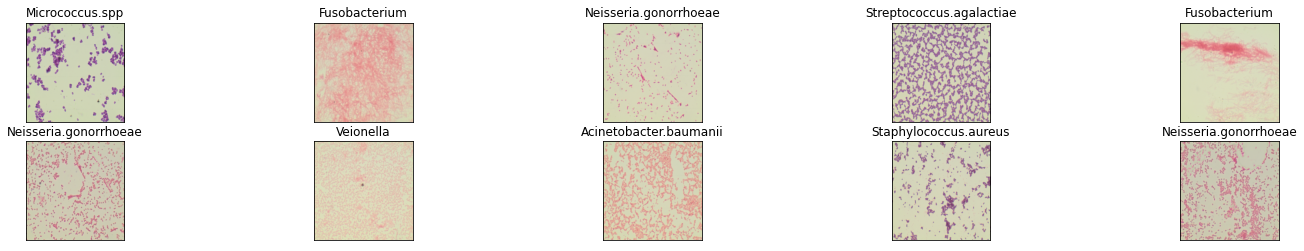

In [ ]:
original_loader = torch.utils.data.DataLoader(dataset=original, batch_size=64, shuffle=True)
dataset_iterable = iter(original_loader)
images, labels = next(dataset_iterable)
fig = plt.figure(figsize=(25,4))
for i in np.arange(10): #showing sample of 16 images
  ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
  plt.imshow(convert_to_image(images[i]))
  ax.set_title(classes[labels[i].item()])

plt.savefig('Figure1.jpg', dpi=300)

# Neural Network Construction

In [ ]:
get_ipython().run_line_magic('load_ext', 'autotime')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # use gpu for accelerated computation

time: 801 ms (started: 2022-12-03 16:53:57 +00:00)


In [ ]:
model = models.alexnet(pretrained=True) #pretrained model
for parameter in model.features.parameters(): #Freezing feature extraction layer only
    parameter.require_grad = False

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

'\nfor parameter in model.features.parameters(): #Freezing feature extraction layer only\n    parameter.require_grad = False\n'

time: 7.03 s (started: 2022-12-03 16:53:58 +00:00)


In [ ]:
model.classifier = nn.Sequential(nn.Dropout(p=0.6, inplace=False),
                                 nn.Linear(in_features=9216, out_features=4096, bias=True),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(p=0.6, inplace=False),
                                 nn.Linear(in_features=4096, out_features=4096, bias=True),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(p=0.6, inplace=False),
                                 nn.Linear(in_features=4096, out_features=33, bias=True))
model.to(device)


'''
number_of_inputs = model.classifier[-1].in_features #resizing last layer of Network to have 33 activations: corresponding to classes
last_layer = nn.Linear(number_of_inputs, len(classes)) #input kept same, output channged
model.classifier[-1] = last_layer
model.to(device)
'''

'\nnumber_of_inputs = model.classifier[-1].in_features #resizing last layer of Network to have 33 activations: corresponding to classes\nlast_layer = nn.Linear(number_of_inputs, len(classes)) #input kept same, output channged\nmodel.classifier[-1] = last_layer\nmodel.to(device)\n'

time: 5.63 s (started: 2022-12-03 16:54:05 +00:00)


# Neural Network Complexity

In [ ]:
from torchsummary import summary

print(summary(model, (3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

# Neural Network Implementation

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00008)

time: 1.03 ms (started: 2022-12-03 16:54:17 +00:00)


In [ ]:
epochs = 20
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

time: 876 µs (started: 2022-12-03 16:54:17 +00:00)


In [ ]:
torch.random.manual_seed(42)
for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:

    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    score, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)

        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        val_score, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)

    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print("epoch number: {}".format(e+1))
    print("training loss: {:.4f}".format(epoch_loss))
    print("training acc: {:.4f}".format(epoch_acc.item()))
    print("validation loss: {:.4f}".format(val_epoch_loss))
    print("validation acc: {:.4f}".format(val_epoch_acc.item()))

epoch number: 1
training loss: 0.0241
training acc: 0.1570
validation loss: 0.0168
validation acc: 0.3445
epoch number: 2
training loss: 0.0112
training acc: 0.5201
validation loss: 0.0084
validation acc: 0.6301
epoch number: 3
training loss: 0.0060
training acc: 0.7405
validation loss: 0.0057
validation acc: 0.7697
epoch number: 4
training loss: 0.0037
training acc: 0.8378
validation loss: 0.0039
validation acc: 0.8368
epoch number: 5
training loss: 0.0025
training acc: 0.8950
validation loss: 0.0035
validation acc: 0.8676
epoch number: 6
training loss: 0.0019
training acc: 0.9186
validation loss: 0.0025
validation acc: 0.8903
epoch number: 7
training loss: 0.0013
training acc: 0.9406
validation loss: 0.0024
validation acc: 0.9084
epoch number: 8
training loss: 0.0012
training acc: 0.9508
validation loss: 0.0020
validation acc: 0.9184
epoch number: 9
training loss: 0.0009
training acc: 0.9651
validation loss: 0.0017
validation acc: 0.9429
epoch number: 10
training loss: 0.0007
trainin

Plots of loss and accuracy

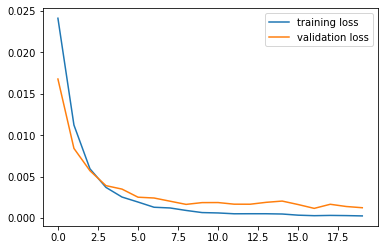

time: 223 ms (started: 2022-12-03 17:41:25 +00:00)


In [ ]:
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

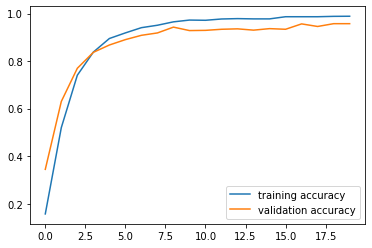

time: 181 ms (started: 2022-12-03 17:41:25 +00:00)


In [ ]:
for i in range(len(running_corrects_history)):
  running_corrects_history[i] = running_corrects_history[i].cpu()

for i in range(len(val_running_corrects_history)):
  val_running_corrects_history[i] = val_running_corrects_history[i].cpu()

plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

Sample of Validation Dataset Classification

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

time: 3.42 s (started: 2022-12-03 17:41:25 +00:00)


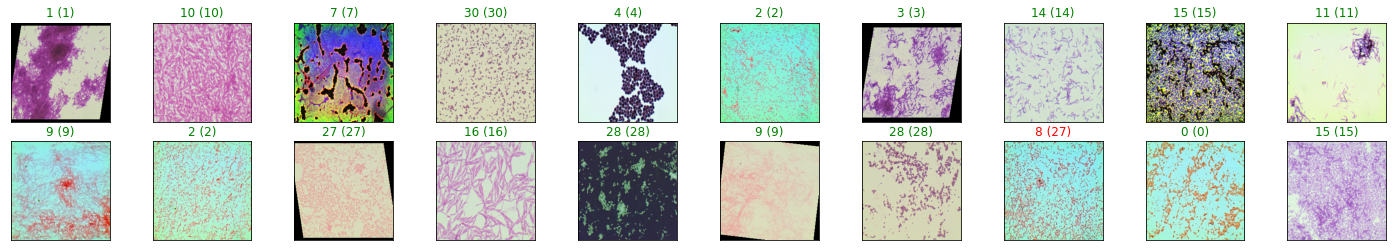

time: 1.27 s (started: 2022-12-03 17:41:29 +00:00)


In [ ]:
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(convert_to_image(images[idx].cpu()))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))

#Confusion Matrix

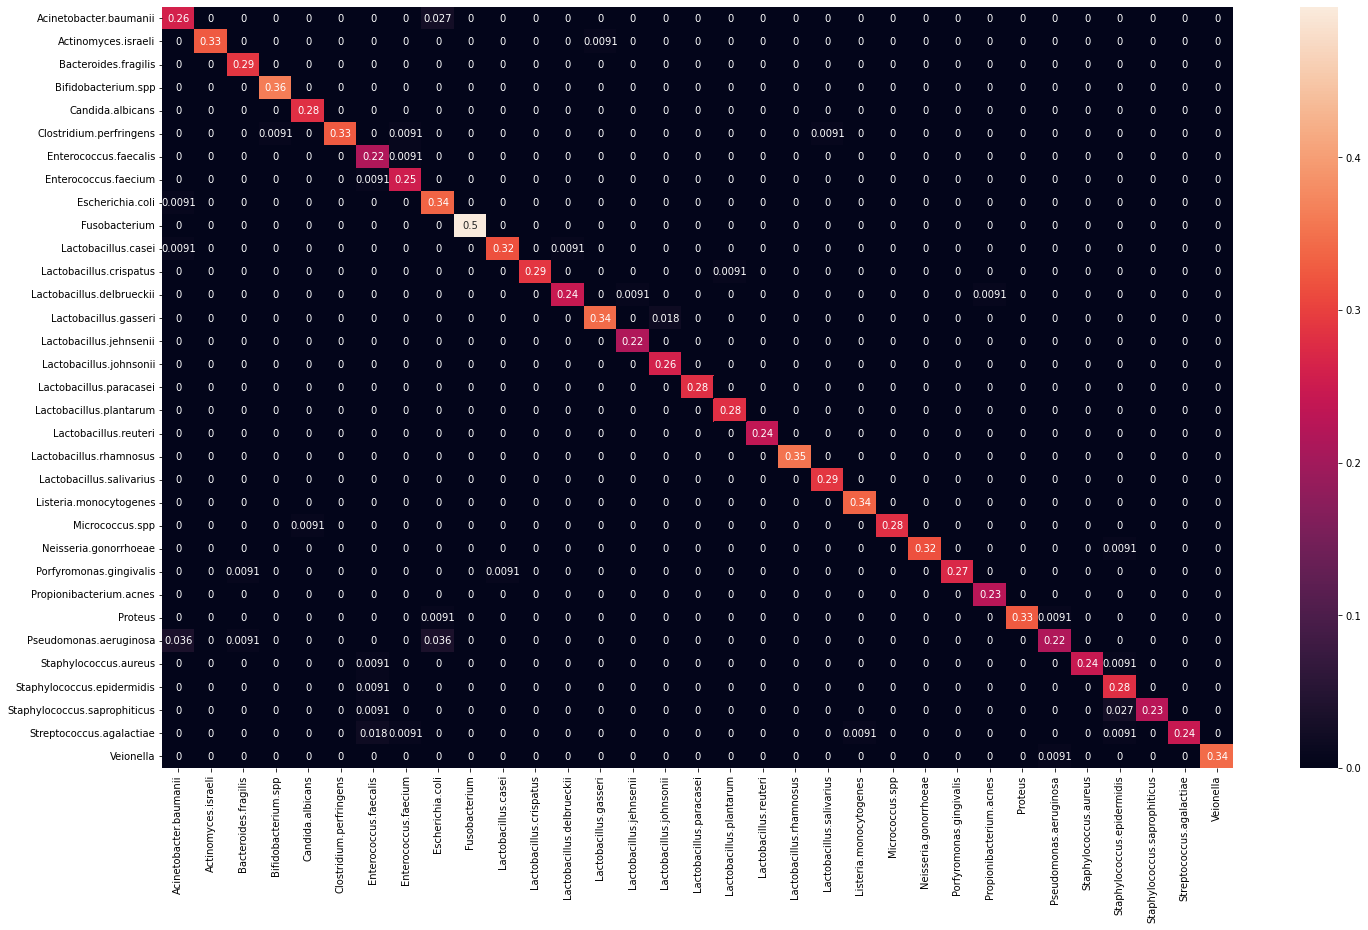

time: 35.1 s (started: 2022-12-03 17:41:30 +00:00)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (24,14))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))

(0.9624697594270825, 0.9592021758839528, 0.9592657408950162, None)
time: 8.37 ms (started: 2022-12-03 17:42:05 +00:00)


In [1]:
running_loss = 0.0
running_corrects = 0.0
test_running_loss = 0.0
test_running_corrects = 0.0
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
      test_inputs = test_inputs.to(device)
      test_labels = test_labels.to(device)

      test_outputs = model(test_inputs)
      test_loss = criterion(test_outputs, test_labels)
      test_score, test_preds = torch.max(test_outputs, 1)
      test_running_loss += test_loss.item()
      test_running_corrects += torch.sum(test_preds == test_labels.data)

test_epoch_loss = test_running_loss/len(test_loader.dataset)
test_epoch_acc = test_running_corrects.float()/len(test_loader.dataset)

print("test acc: {:.6f}".format(test_epoch_acc.item()))

test acc: 0.957412
time: 2min 21s (started: 2022-12-03 17:42:06 +00:00)
